# Hough indexing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
from pyebsdindex import tripletvote, ebsd_pattern, ebsd_index, pcopt
from pyebsdindex.EBSDImage import IPFcolor

### An example of indexing a file of patterns. 
Currently the only types of files that can be indexed are the EDAX UP1/2 files.  HDF5 files should be coming along soon.  

Define the environmental conditions of the data collection

In [2]:
file = '~/Desktop/SLMtest/scan2v3nlparl09sw7.up1'
#file = '~/Desktop/SLMtest/scan2v3lam0.90sr7dt0.0.up1'
PC = np.array([0.46424919, 0.70189953, 0.64026537])
cam_elev = 5.3
sampleTilt = 70.0
vendor = 'EDAX'

Set up some phases.  There are some shortcuts for common phases (FCC, BCC, HCP). It should be noted that the setting up of the phase information also is initializing the method used for indexing the detected bands.  The default is to use triplet voting.  

For the first phase, we will use the shortcut method for FCC.  In its shortest form it will act as a generic FCC phase. This will automatically define the space group, set a lattice parameter = [1.0, 1.0, 1.0, 90, 90, 90], and define a set of reflecting pole families and set the phase name to "FCC".   

In [3]:
fcc = tripletvote.addphase(libtype = 'FCC' )

It is possible to override the defaults for any of the parameters and to set a phase name.  For example:

In [4]:
austenite = tripletvote.addphase(libtype = 'FCC', phasename = 'Austenite', latticeparameter=[0.355, 0.355, 0.355, 90, 90, 90])

If the phase is not one of the shortcut phases, then the space group, lattice parameters, and reflecting families need to be defined.  It should be noted that PyBSDIndex does no checks to make sure that the space group and lattice parameters have a matching specification.  Thus, if hexagonal lattice parameters are input to a cubic space group, it will produce nonsense results. Here, we will use a BCC lattice as an example: 

In [5]:
ferrite = tripletvote.addphase(phasename = 'Ferrite',
                              spacegroup = 229, 
                              latticeparameter=[0.286,0.286,0.286,90, 90, 90],
                              polefamilies =[[0, 1, 1], [0, 0, 2], [1, 1, 2], [0, 1, 3]])

Finally, we need to put these into a list.  As an implementation note, the default behavior is that if PyEBSDIndex matches at least seven bands to a phase, then the second phase is not even checked.  This is set as a reasonable trade-off for speed to accuracy, but can be changed if desired. Thus, putting the phase that is most likely to be found in the scan first does tend to index faster.  

In [6]:
phaselist = [austenite, ferrite]

For the truly lazy among us, there is also the option to define the shortcut phases as part of the list, which can be mixed and matched with the fully initiated phases above:

In [7]:
phaselistlazy = [austenite, 'BCC', 'HCP']

Define the radon and indexing parameters

In [8]:
nT = 180 # 180/nTheta == degree resolution 
nR = 90 
tSig = 2.0 # amount of gaussian kernel size in theta in units of radon pixels.
rSig = 1.5 # amount of gassian 2nd derivate in rho in units of radon pixels.
rhomask = 0.1 # fraction of radius to not analyze
backgroundsub = False # enable/disable a simple background subtract of the patterns
nbands = 8

Now initialize the indexer object.  It is easiest to run it over a 1000 patterns to give some idea of timing.  
Verbose = 1 is only timing, verbose = 2 is radon and peak ID image of last pattern, verbose = 0 nothing is reported. 
Here, "dat1" is a temporary indexed data of the 1000 points.  

The indexer object will hold all the information needed to index a set of patterns.  This includes all the environmental conditions, the radon/band finding parameters, the phase information (including a libray of triplet angles).  The only parameter used are the angles between bands, no bandwidth infomation is currently used/collected.  


Radon Time: 0.026666632969863713
Convolution Time: 0.03771136200521141
Peak ID Time: 0.030311049020383507
Band Label Time: 0.05217741505475715
Total Band Find Time: 0.14690838003298268


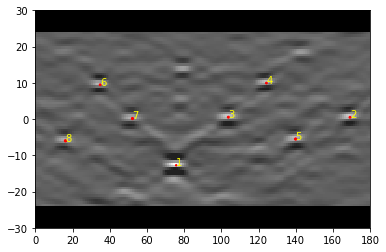

Band Vote Time:  0.6370859500020742


In [16]:
dat1,bnd1, indxer=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 0)
imshape = (indxer.fID.nRows, indxer.fID.nCols)
indxer.bandDetectPlan.useCPU = False
dat1,bnd1=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000, ebsd_indexer_obj=indxer, verbose=2)

The data output *dat1* here, is a complex numpy array (or array of structured data), that is \[nphases+1, npoints\].  The data is stored for each phase used in indexing and the dat1\[-1\] layer uses the best guess on which is the most likely phase, based on the fit, and number of bands matched for each phase.  Each data entry contains the orienation expressed as a quaternion (quat) (using EDAX convention by default), Pattern Quality (pq), Cofidence Metric (cm), Phase ID (phase), Fit (fit) and Number of Bands Matched (nmatch).  There are some other metrics reported, but these are mostly for debugging purposes.  

Now use that indexer object to index the whole file.  Setting *npats = -1* will index to the end of the file/array (latter on will be an example of using an array as input).  

The defaults will be to detect all the GPUs on your machine, and use them.  Scheduling is dynamic, so it does not matter if the GPUs are matched. After radon processing/peak finding, the cpus take over for performing the index voting -- thus the number of CPUs needed will depend highly on the number of phases that need to be indexed.  The number of CPUs needed also is dependant on how fast your GPUs are - on my MacPro with a Radeon 6800 GPU there are dimishing returns of including more than 32 CPUs when using the above conditions.  

The *chunksize* is the number of patterns to analyze per process per cycle. The right number here is going to be a function of how much global memory is on your GPU and the size of your patterns and radon arrays.  Setting this very low may have high I/O penalties.  Setting too high will cause your GPU to run out of memory.  In theory this should fall back to the CPU, but this might not work as well as one might hope.  Guidlines: multiples of 16 are most efficient, avoid powers of 2. For patterns that are <= 120 x 120, 784 -- 1008 works OK with a large GPU (>4GB). For 480x620 patterns, chunks of <= 528 are probably more ideal.    

In [12]:
indxer.bandDetectPlan.useCPU = False
data, bnddata = ebsd_index.index_pats_distributed(filename = file,patstart = 0, npats = -1, chunksize = 1008, ncpu = 42, ebsd_indexer_obj = indxer)

num cpu/gpu: 42 2


Display the results as an IPF map.  So far the only implementation is for cubic IPFs - further, more flexible representations are needed here.  

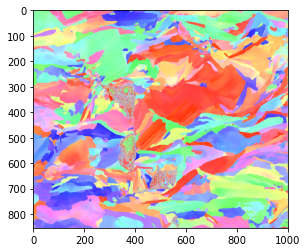

In [30]:
ipfim = IPFcolor.qu2ipf_cubic(data[-1]['quat']).reshape(imshape[0], imshape[1], 3); plt.imshow(ipfim)

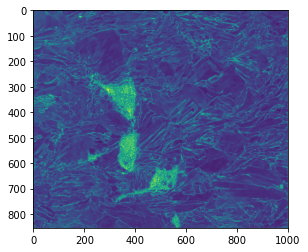

In [31]:
fit = (data[-1]['fit']).reshape(imshape[0],imshape[1]); plt.imshow(fit.clip(0, 2.0))

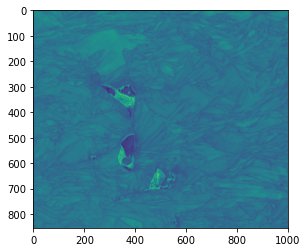

In [32]:
pq = (data[-1]['pq']).reshape(imshape[0],imshape[1]); plt.imshow(pq)

### An example of indexing an array of patterns.

It is also possible to index a numpy array of patterns.  
Here we will read part of the UP file above into an array -- note that patterns can take up a lot of RAM.  It is not normally advisable to read in an entire file of patterns if the filesize is > 2GB.  

Here we read in 200cols x 300 rows = 60000 patterns starting at column 10, row 5 (0-index based) of the EBSD scan data.  However, this is something specific to the UP files (and potentially HDF5 in the future).  What is important here is that the patterns are returned as a *(N, pH, pW)* numpy float32 array where *N* is the number of patterns, *pH* is the pattern height, and *pW* is the pattern width.  

It should be noted that patterns are expected to be arranged so that *pats[0,0,0]* coresponds to the top-left pixel as one looks at the detector towards the sample (same as the EBSD vendor standards and EMSoft version >=5.0). 

(60000, 60, 60)
float32


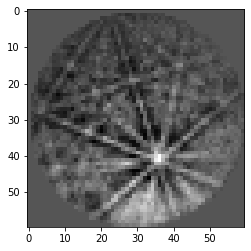

In [33]:
startcolrow = [5,10]
ncol = 200
nrow = 300

f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])
print(pats.shape)
print(pats.dtype)
plt.imshow(pats[0, :, :], cmap='gray')

If the array holds a small number of patterns that can all fit on the GPU at one time, one can avoid the distributed indexing method.  It should be noted that there is built in chuncking (set to fairly conservative limits) to the GPU when using *index_pats*, but no multi-processing of the band voting so it may take a long while.  Here we index just the first 256 patterns. (Note, one does not need to intitate a new indexer object if they have defined one above).  

Radon Time: 1.2862144199993963
Convolution Time: 2.1463325300010183
Peak ID Time: 1.6447724460003883
Band Label Time: 1.938284111000712
Total Band Find Time: 7.018114552000043


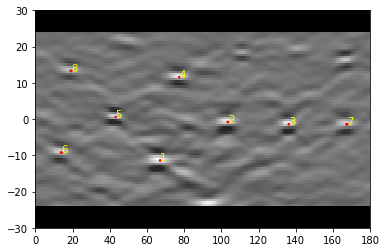

Band Vote Time:  43.272813240999994


In [34]:
datasm, bnddatsm, indxer=ebsd_index.index_pats(patsin = pats,
                                     return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, verbose = 2)


If the array is large, then the distributed indexing works on large input arrays as well.  

In [35]:
datasm, bnddatsm = ebsd_index.index_pats_distributed(patsin = pats,patstart = 0, npats = -1, chunksize = 1008, ncpu = 12, ebsd_indexer_obj = indxer)

num cpu/gpu: 12 2


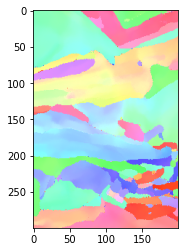

In [36]:
ipfim = IPFcolor.qu2ipf_cubic(datasm[-1]['quat']).reshape(nrow, ncol, 3); plt.imshow(ipfim)

Todo: write an exporter for .ang files and hdf5 files for the indexed data.   

And of course, one can index a single pattern as well.  In this case, *pat* can be a 2D array *(pH, pW)*:

(60, 60)


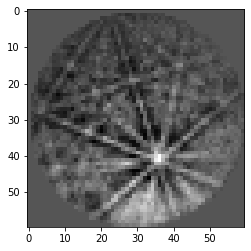

In [37]:
pat1 = pats[0,:, :]
print(pat1.shape)
plt.imshow(pat1, cmap='gray')

Radon Time: 0.007740249999869775
Convolution Time: 0.015711572999862256
Peak ID Time: 0.014265244000171151
Band Label Time: 0.009968713000034768
Total Band Find Time: 0.047706499000014446


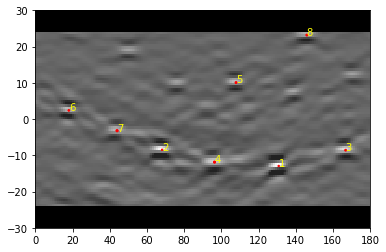

Band Vote Time:  0.0010915779998867947
('quat', 'iq', 'pq', 'cm', 'phase', 'fit', 'nmatch', 'matchattempts', 'totvotes')
[([ 0.65859226, -0.57491329,  0.48512319, -0.01965797], 0., 293405.7, 0.7235495, 0, 0.6052132, 8, [0, 1], 288)]


In [38]:
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxer, verbose=2)
dat1 = dat1[-1]
print(dat1.dtype.names)
print(dat1)





It should be noted that this is a pretty slow indexing of one point. It may be prefered to run this all on the CPU instead:

Radon Time: 0.006342677000020558
Convolution Time: 0.015601840000044831
Peak ID Time: 0.014300557000069603
Band Label Time: 0.011138725000137129
Total Band Find Time: 0.0474029879999307


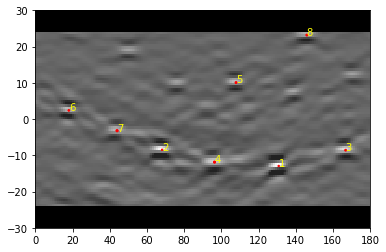

Band Vote Time:  0.0010123380000095494


In [39]:
indxerCPU = copy.deepcopy(indxer)
indxerCPU.bandDetectPlan.useCPU = False
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxerCPU, verbose=2)
dat1 = dat1 = dat1[-1]

### An example of optimizing the Pattern Center

There is nothing special here: we use a Nelder-Mead optimization to minimize the fit of the indexed patterns.  

It is built to optimize using a single pattern, or an array of patterns. Note- there are a lot of iterations still, and indexing is single threaded.  It is not recomended to use a very large array of patterns.    

In [40]:
startcolrow = [560,460]
ncol = 60
nrow = 2
f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])

Single pattern optimization:

In [41]:
newPC = pcopt.optimize(pats[0,:,:], indxer, PC0 = [0.45, 0.65, 0.65])
print(newPC)
print(pcopt.optimize(pats[0,:,:], indxer, PC0 = newPC))

[0.46838947 0.70615405 0.64070127]
[0.46844258 0.70618324 0.64076734]


Multiple pattern optimization (here using 120 patterns): 

In [42]:
newPC = pcopt.optimize(pats, indxer, PC0 = [0.45, 0.65, 0.65])
print(newPC)
print(pcopt.optimize(pats, indxer, PC0 = newPC))

[0.46424919 0.70189953 0.64026537]
[0.46430816 0.7018663  0.64027081]


### Loading data from an HDF5 File
There is some limited support for specific types of HDF5 files using the _"filename"_ keyword to _ebsd_index.index_pats_ or _ebsd_index.index_pats_distributed_.  However, probably the easiest method is to just point an h5py Dataset at the _"patsIn"_ keyword (This makes the important assumption that the patterns are stored in \[npatterns, nrows, ncols\] and the first point stored is the upper left corner of the detector).  See below: 

Radon Time: 0.01922415099988939
Convolution Time: 0.053790638000009494
Peak ID Time: 0.035985807000088244
Band Label Time: 0.04844529600018177
Total Band Find Time: 0.1574961930000427


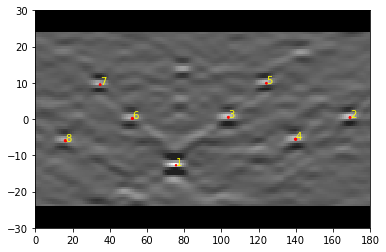

Band Vote Time:  0.7439625819999947
num cpu/gpu: 36 2


In [43]:
f = h5py.File('/Users/dave/Desktop/SLMtest/scan2v3_NLPAR_l0.90sr3.oh5', 'r') # this is an HDF5 file type used by EDAX.  
h5pats = f['/scan2v3/EBSD/Data/Pattern'] # location of the pattern array within the HDF5 file.  

h5data, h5bnddata, indxer=ebsd_index.index_pats(patsin = h5pats[0:1000,:,:],
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 2)
indxer.bandDetectPlan.useCPU = False
h5data, h5banddata = ebsd_index.index_pats_distributed(patsin = h5pats, chunksize = 1008, ncpu = 36, ebsd_indexer_obj = indxer)